# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
data_dir = "D:/Udacity/face_generator"
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

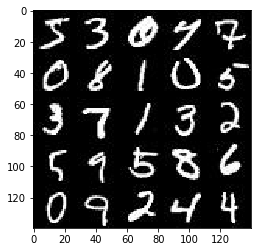

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

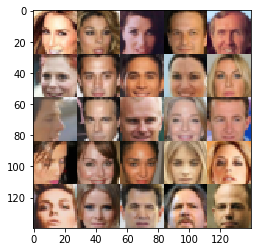

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope("discriminator", reuse=reuse):
        #input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x1 = tf.nn.leaky_relu(x1, alpha)
        #now it's 14x14x64

        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.leaky_relu(x2, alpha)
        #now it's 7x7x128

        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.leaky_relu(x3, alpha)
        #now it's 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope("generator", reuse=not is_train):
        #first fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        #reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.leaky_relu(x1, alpha)
        #conv transpose 1 Done. Now it's (7x7x256)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2, alpha)
        #conv transpose 2 Done. Now it's (14x14x128)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, kernel_initializer=kernel_init, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3, alpha)
        #conv transpose 3 Done. Now it's (28x28x64)
        
        logits = tf.layers.conv2d(x3, out_channel_dim, 3, strides=1, kernel_initializer=kernel_init, padding="same")
        #conv transpose 4 Done.
        #logits are (28x28x3)
        
        out = tf.nn.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # TODO: Implement Function
    gen_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(gen_out, reuse=True, alpha=alpha)
    
    def get_loss_function(logits, labels):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                      labels=labels))
    
    smooth = 0.1
    real_labels = tf.ones_like(d_logits_real)*(1-smooth)
    fake_labels = tf.zeros_like(d_logits_fake)
    g_labels = tf.ones_like(d_logits_fake)
    
    d_loss_real = get_loss_function(d_logits_real, real_labels)
    d_loss_fake = get_loss_function(d_logits_fake, fake_labels)
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = get_loss_function(d_logits_fake, g_labels)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # TODO: Implement Function
    #get the vars from each model
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    updt_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_up_ops = [var for var in updt_ops if var.name.startswith("discriminator")]
    g_up_ops = [var for var in updt_ops if var.name.startswith("generator")]
    
    #optimize the vars
    with tf.control_dependencies(d_up_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(d_loss,
                                                                   var_list=d_vars)
    with tf.control_dependencies(g_up_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(g_loss,
                                                                   var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps=0
    samples, losses = [], []
    print_every_n_steps = 10
    show_every_n_steps = 100
    
    input_real, input_z, learn_rate = model_inputs(image_width=data_shape[1],
                                                   image_height=data_shape[2],
                                                   image_channels=data_shape[3],
                                                   z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                #sample noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={input_z:batch_z, input_real:batch_images})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                if steps % print_every_n_steps==0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                    print(f"Epoch {epoch_i+1}/{epoch_count}...",
                          f"Discriminator Loss: {train_loss_d:.4f}...",
                          f"Generator Loss: {train_loss_g:.4f}")
                    
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every_n_steps==0:
                    show_generator_output(sess, 50, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.8294
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.1422
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 1.3980
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 1.4822
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.9722
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 0.7087... Generator Loss: 1.4182


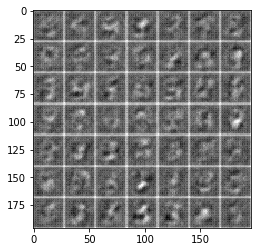

Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 0.8266... Generator Loss: 2.7596
Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.6755
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 1.2252
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 2.1873
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 2.0739
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 2.0295


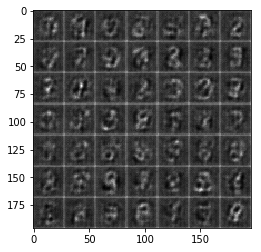

Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 2.7180
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 2.1191
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.3093
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.3106
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 0.7466... Generator Loss: 2.0440


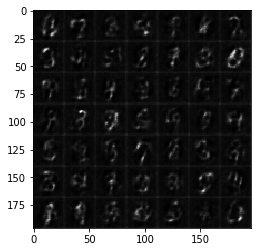

Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.5948
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.6525
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.6772
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 1.3671
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.9679
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 2.0016
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 0.6620... Generator Loss: 1.5973
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 1.5599
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.6275


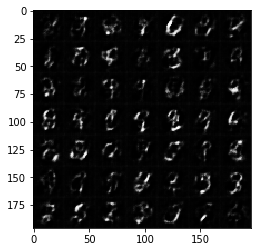

Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 1.8133
Epoch 1/2... Discriminator Loss: 0.6955... Generator Loss: 1.8805
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 2.1984
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.4409
Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 2.2121
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.5541
Epoch 1/2... Discriminator Loss: 0.6922... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.4997
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.5530
Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 1.7013


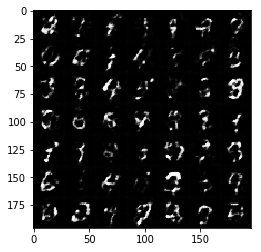

Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 2.3340
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.7845
Epoch 1/2... Discriminator Loss: 0.5944... Generator Loss: 2.4364
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 1.7402
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 2.8239
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.4632
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 1.5679
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 2.0409


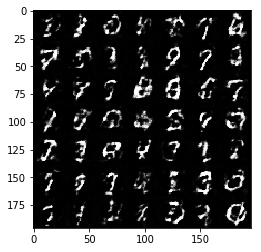

Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 2.0991
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 0.6231... Generator Loss: 1.8847
Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.0506
Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 2.1758
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 2.4255
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.0260


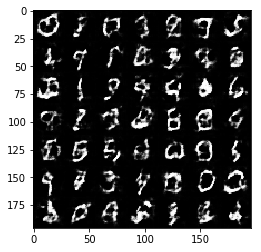

Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 1.6096
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 0.6672... Generator Loss: 1.7569
Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 2.5952
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.6813
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.8389


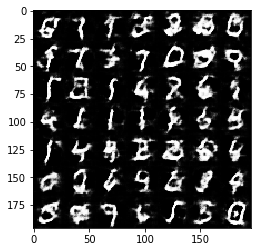

Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.8830
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 1.8067
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 2.0970
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 2.0280
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 1.5656
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.8426
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.4983
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.3546
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.5915


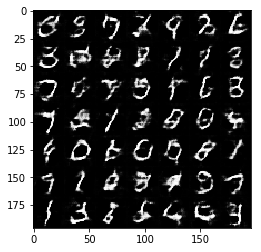

Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.8744
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.1942


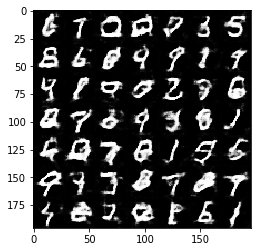

Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.6276
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 2.1077
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.4651
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 2.2087
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.8508
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.2747


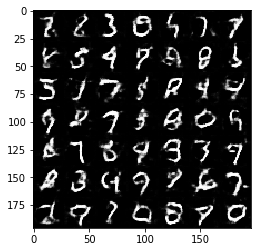

Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.8173
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.7665
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 2.1500
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.5519
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.5709
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.7370
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.3360
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.2368


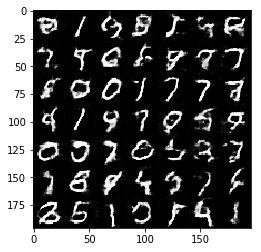

Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.4986
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.9964
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.9192... Generator Loss: 1.9467
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 0.8833
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 2.4640
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.5651


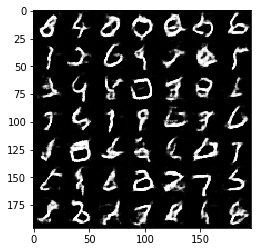

Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.3974
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 1.5501
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.1271
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.6769
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.8914
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.2727


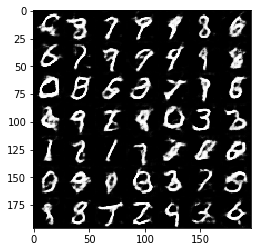

Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.2964
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.6885
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.0869
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.4635
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.4316
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.8672


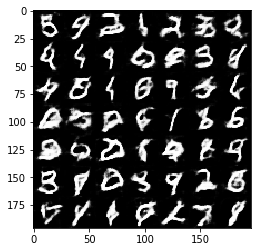

Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.3925
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 2.1158
Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.3835


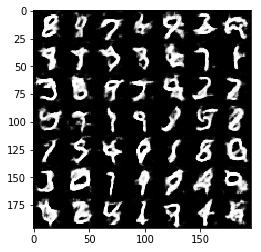

Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.6939
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.6602
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 2.4320
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.1701


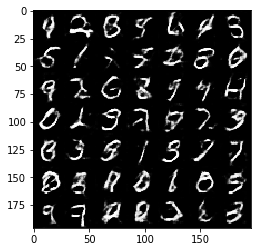

Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.0891
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.9439
Epoch 2/2... Discriminator Loss: 0.6581... Generator Loss: 1.7537
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 1.5736
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 2.2295
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 1.0241


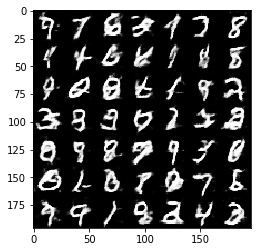

Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.5545
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 1.5378
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.5991
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.4376
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 1.9342


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6684


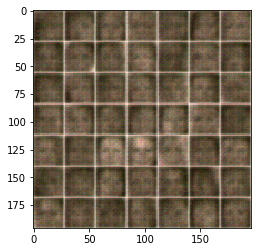

Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 1.6266
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.0713


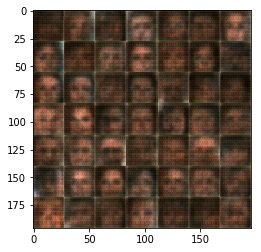

Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.4979
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8521


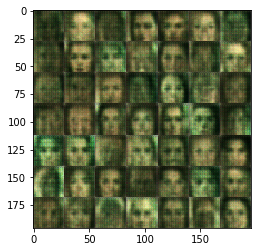

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 2.2552
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9821


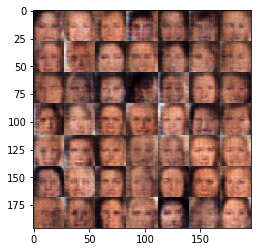

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7584


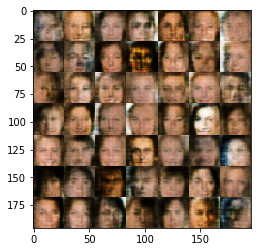

Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7085


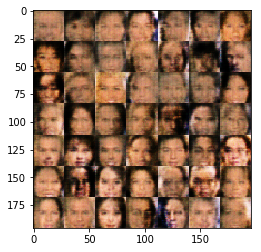

Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8308


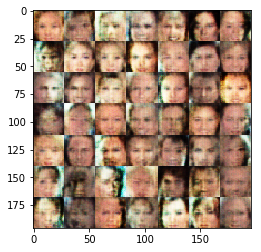

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7373


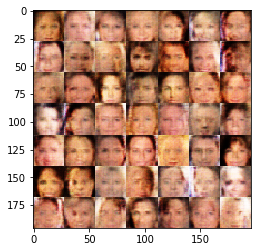

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.9887


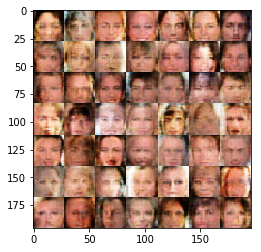

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9298


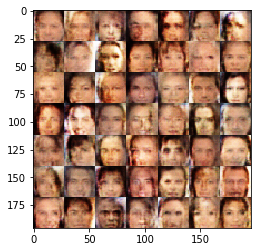

Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8459


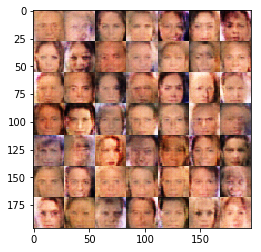

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.2410


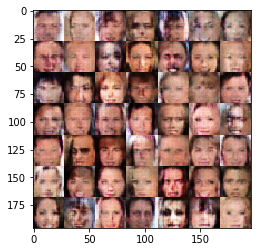

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8347


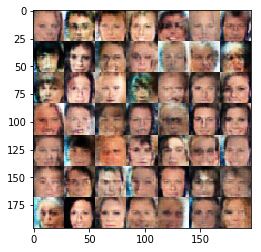

Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.1136


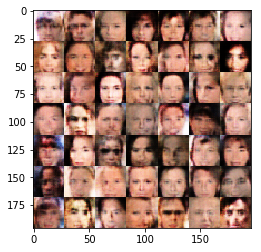

Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.2113


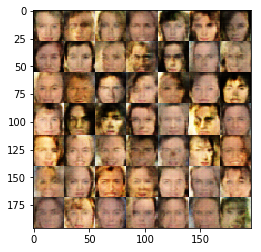

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.1839


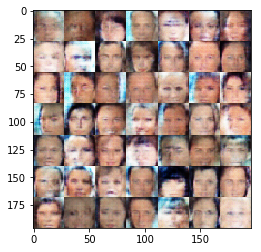

Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.1663


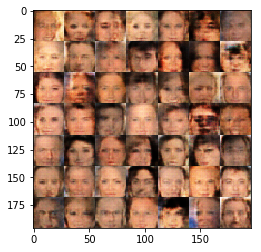

Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.9838


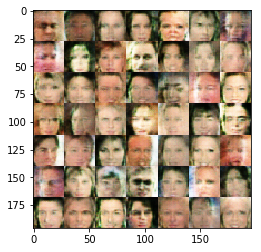

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 1.0138


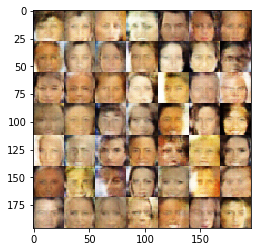

Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7451


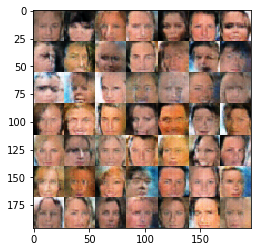

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8042


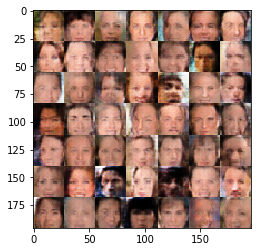

Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1545


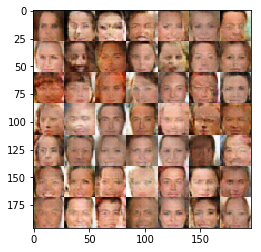

Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.4743


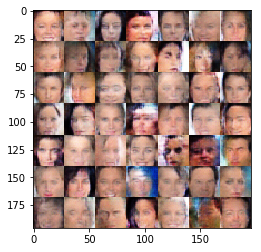

Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.9486


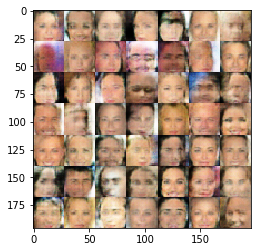

Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.6961


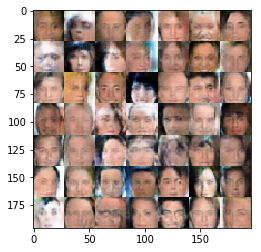

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9181


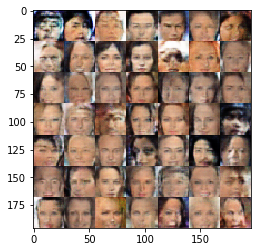

Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7292


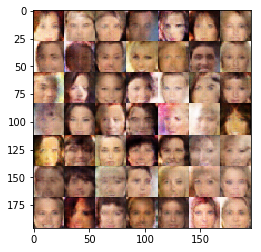

Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.2173


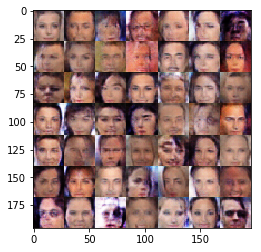

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.2116


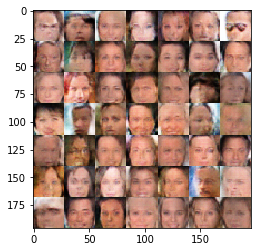

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6666


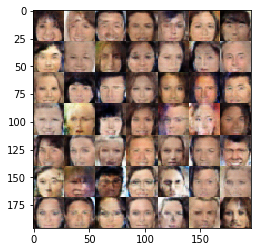

Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.1048


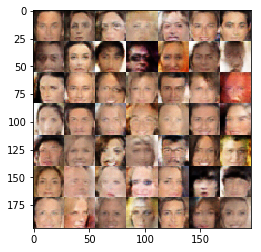

Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.6044
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.5559


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.